# Graphs

In [1]:
import math
import matplotlib.pyplot as plt
import random
import statistics
%matplotlib inline

In [2]:
def calculate_gini_coefficient(voting_weights):
    """A measure of inequality. 0 is total equality, 1 is total inequality."""
    numerator = sum([sum([abs(i - j) for j in voting_weights]) for i in voting_weights])
    
    n = len(voting_weights)
    x_bar = statistics.mean(voting_weights)
    denominator = 2 * n**2 * x_bar
    
    return numerator / denominator

## Parameters

In [3]:
# Shared PoS and PoE
n_validators = 20
commission_rate_base = 0.1
self_stake_base = 0.7
self_stake_max = 4_000_000
delegation_initial = 0
inflation_rate = 1_000_000
fixed_cost = 10_000

# PoE only
engagement_base = 0.7
engagement_max = 10_000

## Proof of Stake

In [4]:
def calculate_voting_weight_pos(self_stake, delegation):
    return self_stake + delegation

In [5]:
def create_validator_pos(i, commission_rate_base, self_stake_base, self_stake_max, delegation_initial):
    self_stake = self_stake_max * self_stake_base**i
    delegation = delegation_initial
    return {
        'commission_rate': commission_rate_base,
        'self_stake': self_stake,
        'delegation': delegation,
        'voting_weight': calculate_voting_weight_pos(self_stake, delegation),
        'reward': 0,
        'yield': 0,
    }

In [6]:
def calculate_reward_pos(validator, total_voting_weight, inflation_rate):
    self_stake = validator['self_stake']
    commission_rate = validator['commission_rate']
    delegation = validator['delegation']
    return inflation_rate * (self_stake + commission_rate * delegation) / total_voting_weight

In [7]:
def calculate_yield_pos(validator, total_voting_weight, inflation_rate):
    commission_rate = validator['commission_rate']
    return inflation_rate * (1 - commission_rate) / total_voting_weight

In [8]:
validators_pos = [create_validator_pos(i, commission_rate_base, self_stake_base, self_stake_max, delegation_initial) for i in range(n_validators)]
validators_pos.reverse()
total_voting_weight_pos = sum([validator['voting_weight'] for validator in validators_pos])

for validator in validators_pos:
    validator['reward'] = calculate_reward_pos(validator, total_voting_weight_pos, inflation_rate)
    validator['yield'] = calculate_yield_pos(validator, total_voting_weight_pos, inflation_rate)

In [9]:
self_stakes_pos = [validator['self_stake'] for validator in validators_pos]
voting_weights_pos = [validator['voting_weight'] for validator in validators_pos]
rewards_pos = [validator['reward'] for validator in validators_pos]
profits_pos = [reward - fixed_cost for reward in rewards_pos]

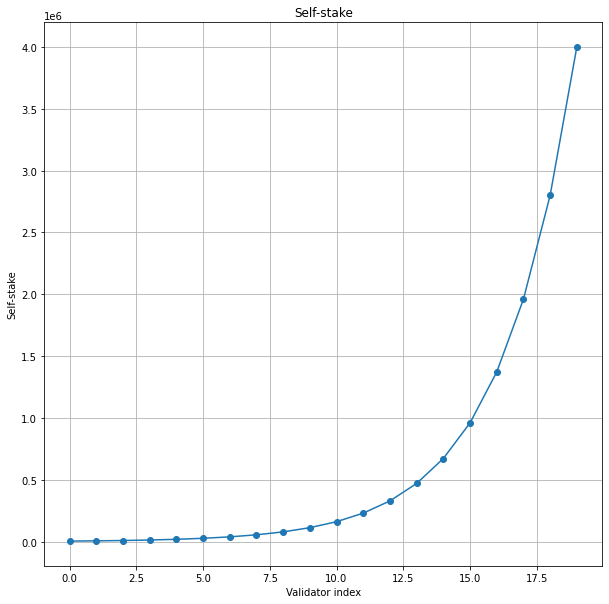

In [10]:
plt.figure(figsize=(10, 10))

plt.plot(self_stakes_pos, marker='o')
plt.title('Self-stake')
plt.xlabel('Validator index')
plt.ylabel('Self-stake')
plt.grid()
plt.show()

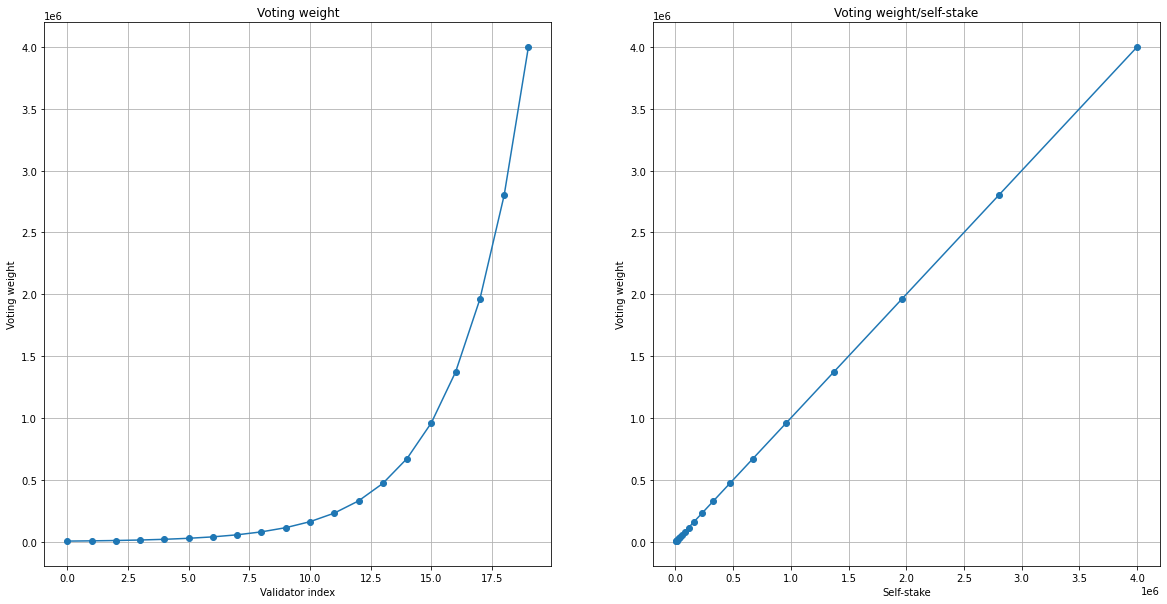

In [11]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(voting_weights_pos, marker='o')
plt.title('Voting weight')
plt.xlabel('Validator index')
plt.ylabel('Voting weight')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(self_stakes_pos, voting_weights_pos, marker='o')
plt.title('Voting weight/self-stake')
plt.xlabel('Self-stake')
plt.ylabel('Voting weight')
plt.grid()

plt.show()

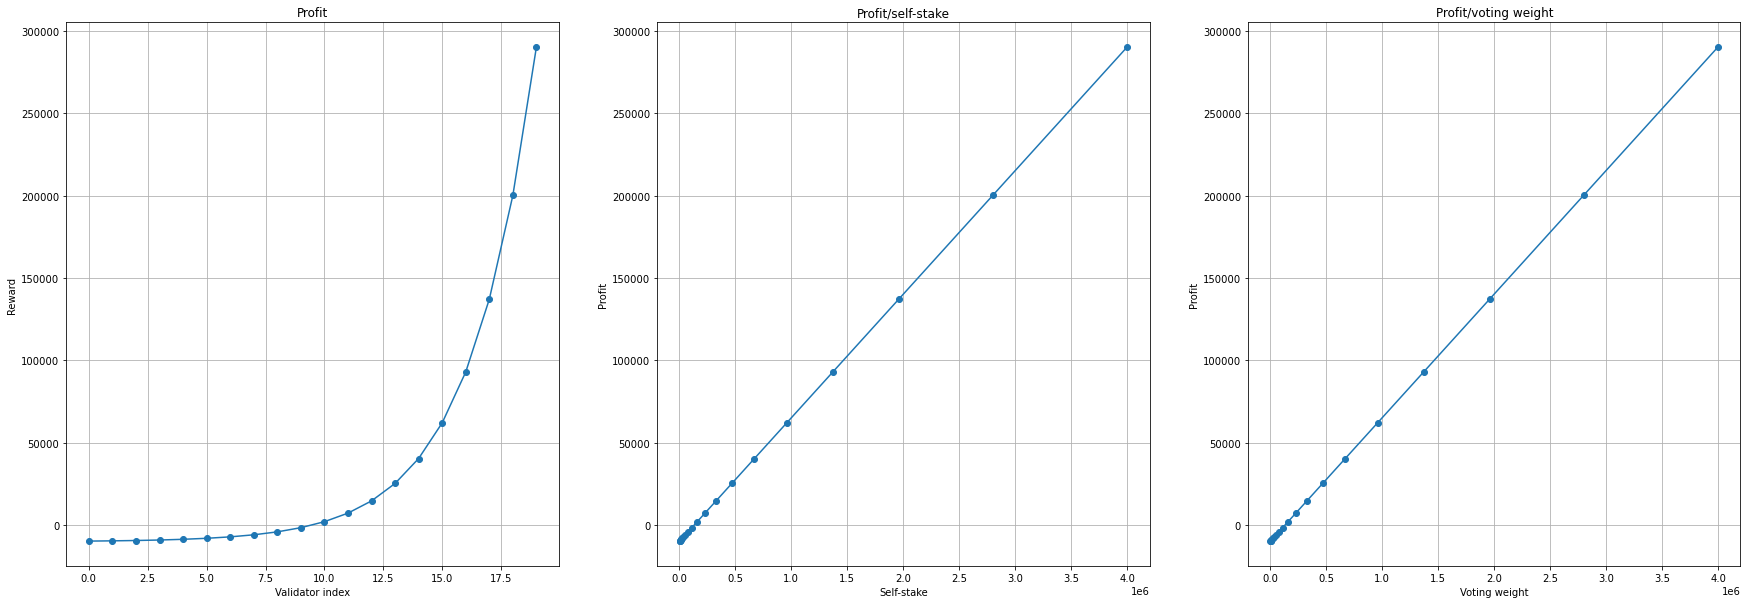

In [12]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.plot(profits_pos, marker='o')
plt.title('Profit')
plt.xlabel('Validator index')
plt.ylabel('Reward')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(self_stakes_pos, profits_pos, marker='o')
plt.title('Profit/self-stake')
plt.xlabel('Self-stake')
plt.ylabel('Profit')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(voting_weights_pos, profits_pos, marker='o')
plt.title('Profit/voting weight')
plt.xlabel('Voting weight')
plt.ylabel('Profit')
plt.grid()

plt.show()

In [13]:
gini_coefficient_pos = calculate_gini_coefficient(voting_weights_pos)
print(f'PoS Gini coefficient: %f' % gini_coefficient_pos)

PoS Gini coefficient: 0.718264


## Proof of Engagement

In [14]:
def default_sigmoidal(stake, engagement):
    return 2000 / (1 + math.exp(-0.00003 * (stake * engagement)**0.68)) - 1000

In [15]:
def calculate_voting_weight_poe(self_stake, delegation, engagement, f=default_sigmoidal):
    return f(self_stake + delegation, engagement)

In [16]:
def create_validator_poe(i, commission_rate_base, self_stake_base, self_stake_max, delegation_initial, engagement_base, engagement_max):
    self_stake = self_stake_max * self_stake_base**i
    engagement = engagement_max * engagement_base**i
    delegation = delegation_initial
    return {
        'commission_rate': commission_rate_base,
        'self_stake': self_stake,
        'delegation': delegation,
        'engagement': engagement,
        'voting_weight': calculate_voting_weight_poe(self_stake, delegation, engagement),
        'reward': 0,
        'yield': 0,
    }

In [17]:
def calculate_reward_poe(validator, total_voting_weight, inflation_rate, f=default_sigmoidal):
    self_stake = validator['self_stake']
    engagement = validator['engagement']
    commission_rate = validator['commission_rate']
    voting_weight = validator['voting_weight']
    self_stake_voting_weight = f(self_stake, engagement)
    return inflation_rate * (self_stake_voting_weight + commission_rate * (voting_weight - self_stake_voting_weight)) / total_voting_weight

In [18]:
def calculate_yield_poe(validator, total_voting_weight, inflation_rate):
    commission_rate = validator['commission_rate']
    return inflation_rate * (1 - commission_rate) / total_voting_weight

### Engagement positively correlated with self-stake

In [19]:
validators_poe_correlated = [create_validator_poe(i, commission_rate_base, self_stake_base, self_stake_max, delegation_initial, engagement_base, engagement_max) for i in range(n_validators)]
validators_poe_correlated.reverse()
total_voting_weight_poe_correlated = sum([validator['voting_weight'] for validator in validators_poe_correlated])

for validator in validators_poe_correlated:
    validator['reward'] = calculate_reward_poe(validator, total_voting_weight_poe_correlated, inflation_rate)
    validator['yield'] = calculate_yield_poe(validator, total_voting_weight_poe_correlated, inflation_rate)

In [20]:
self_stakes_poe_correlated = [validator['self_stake'] for validator in validators_poe_correlated]
engagements_poe_correlated = [validator['engagement'] for validator in validators_poe_correlated]
voting_weights_poe_correlated = [validator['voting_weight'] for validator in validators_poe_correlated]
rewards_poe_correlated = [validator['reward'] for validator in validators_poe_correlated]
profits_poe_correlated = [reward - fixed_cost for reward in rewards_poe_correlated]

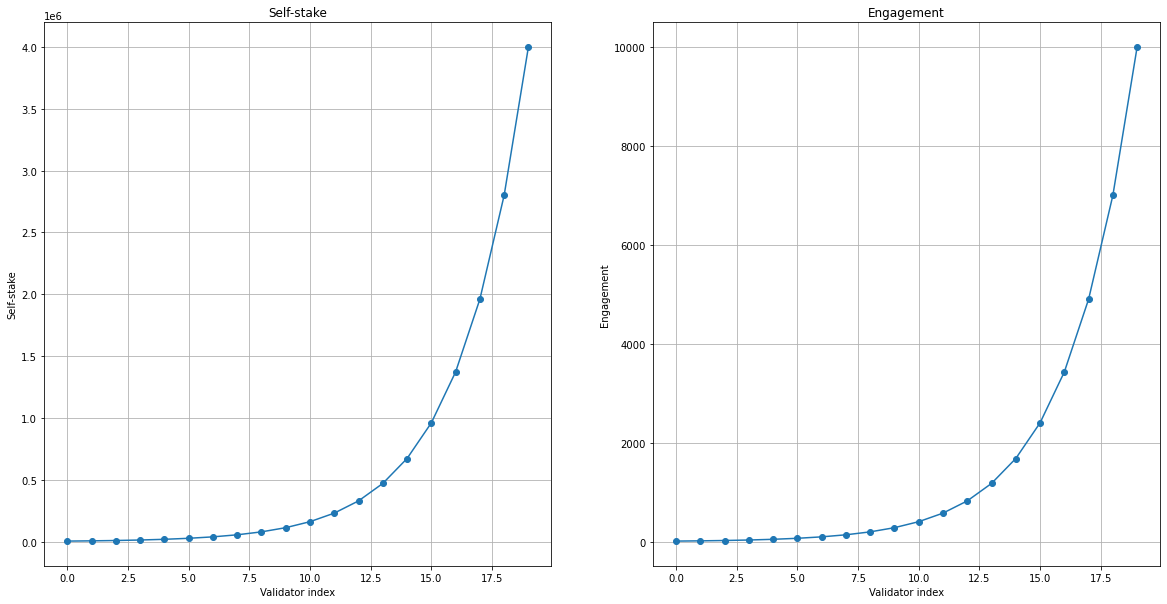

In [21]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(self_stakes_poe_correlated, marker='o')
plt.title('Self-stake')
plt.xlabel('Validator index')
plt.ylabel('Self-stake')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(engagements_poe_correlated, marker='o')
plt.title('Engagement')
plt.xlabel('Validator index')
plt.ylabel('Engagement')
plt.grid()

plt.show()

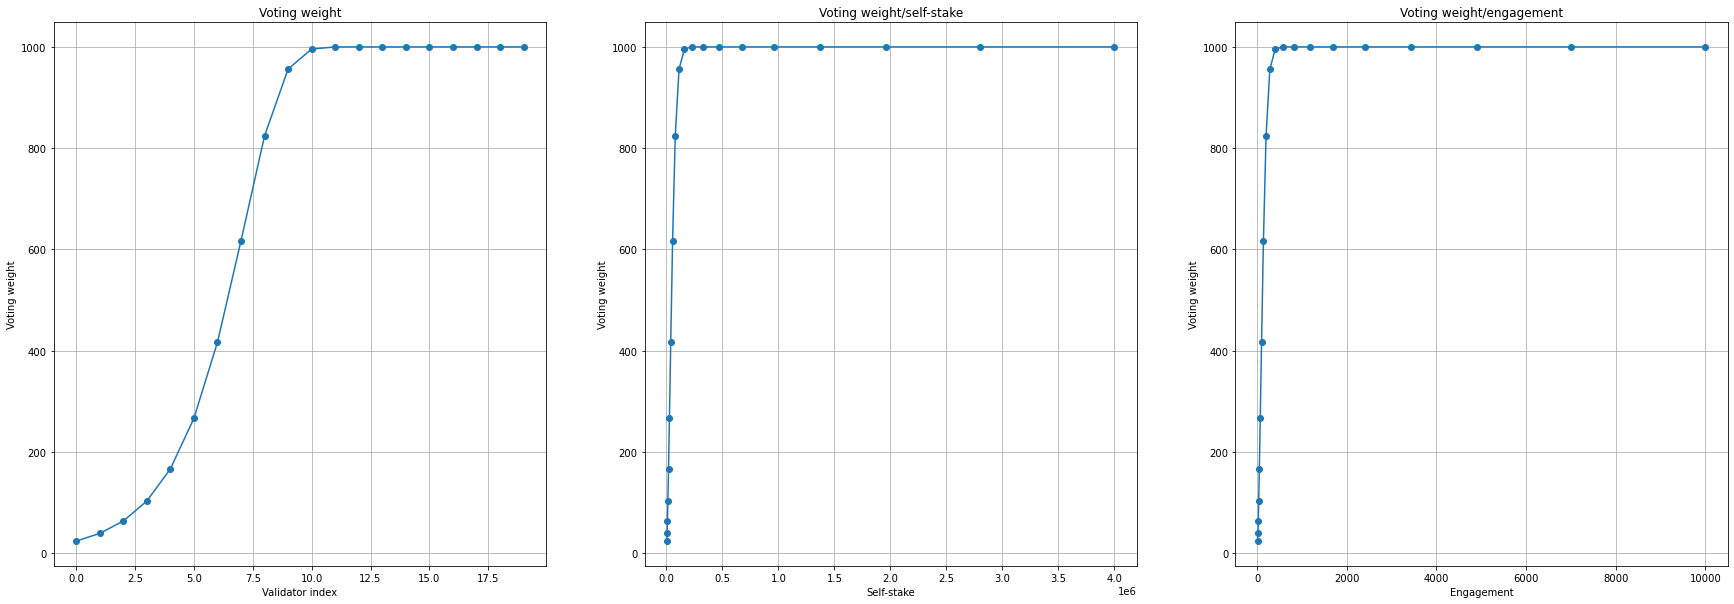

In [22]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.plot(voting_weights_poe_correlated, marker='o')
plt.title('Voting weight')
plt.xlabel('Validator index')
plt.ylabel('Voting weight')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(self_stakes_poe_correlated, voting_weights_poe_correlated, marker='o')
plt.title('Voting weight/self-stake')
plt.xlabel('Self-stake')
plt.ylabel('Voting weight')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(engagements_poe_correlated, voting_weights_poe_correlated, marker='o')
plt.title('Voting weight/engagement')
plt.xlabel('Engagement')
plt.ylabel('Voting weight')
plt.grid()

plt.show()

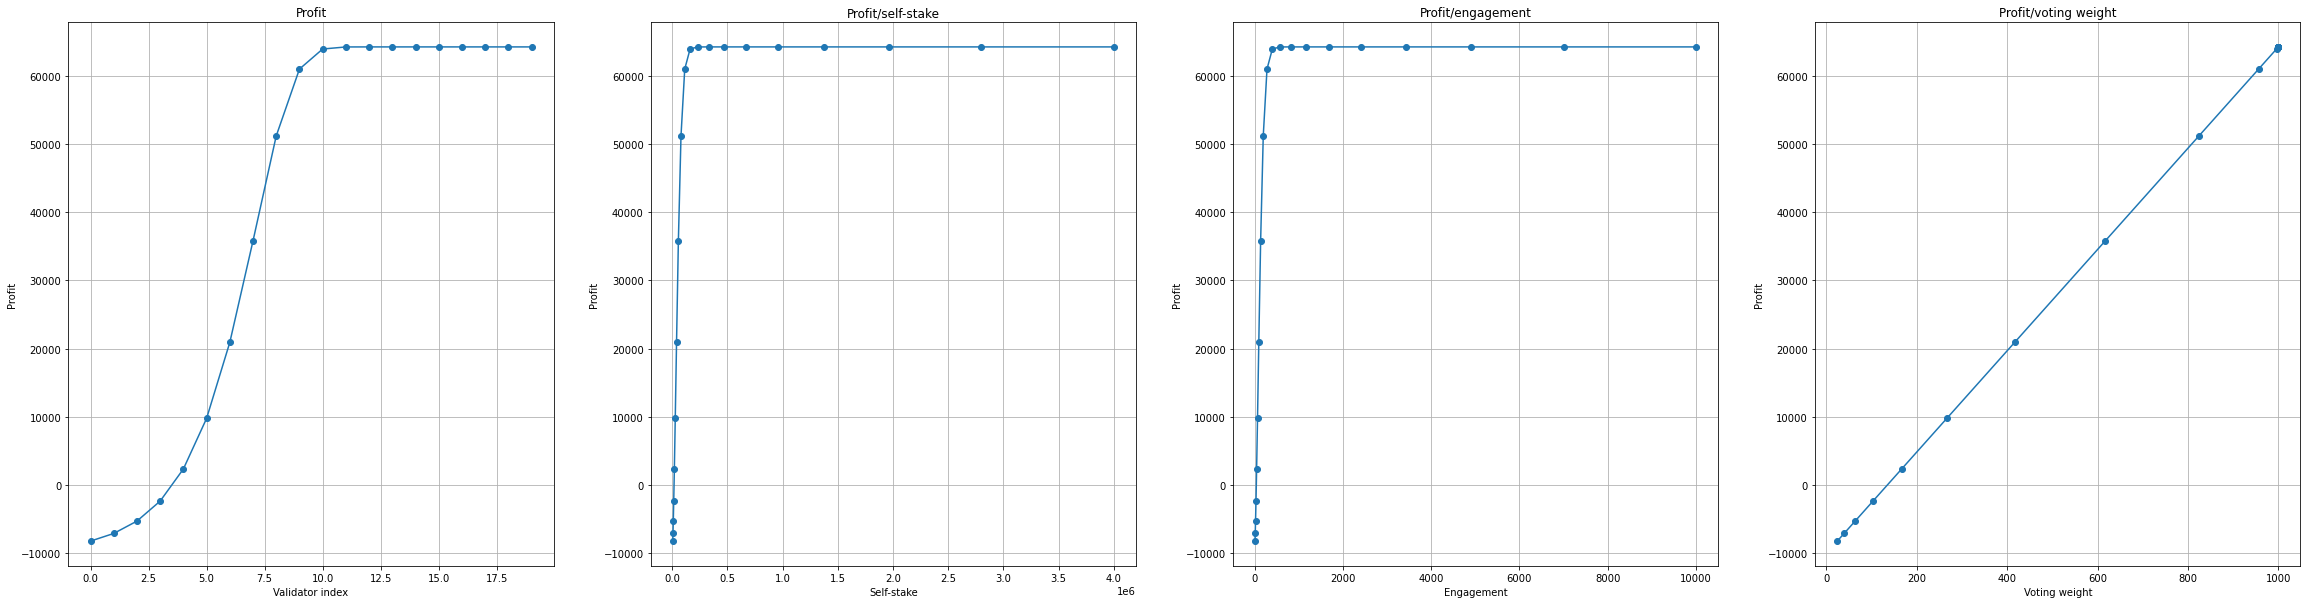

In [23]:
plt.figure(figsize=(40, 10))

plt.subplot(1, 4, 1)
plt.plot(profits_poe_correlated, marker='o')
plt.title('Profit')
plt.xlabel('Validator index')
plt.ylabel('Profit')
plt.grid()

plt.subplot(1, 4, 2)
plt.plot(self_stakes_poe_correlated, profits_poe_correlated, marker='o')
plt.title('Profit/self-stake')
plt.xlabel('Self-stake')
plt.ylabel('Profit')
plt.grid()

plt.subplot(1, 4, 3)
plt.plot(engagements_poe_correlated, profits_poe_correlated, marker='o')
plt.title('Profit/engagement')
plt.xlabel('Engagement')
plt.ylabel('Profit')
plt.grid()

plt.subplot(1, 4, 4)
plt.plot(voting_weights_poe_correlated, profits_poe_correlated, marker='o')
plt.title('Profit/voting weight')
plt.xlabel('Voting weight')
plt.ylabel('Profit')
plt.grid()

plt.show()

In [24]:
gini_coefficient_poe_correlated = calculate_gini_coefficient(voting_weights_poe_correlated)
print(f'PoE (correlated) Gini coefficient: %f' % gini_coefficient_poe_correlated)

PoE (correlated) Gini coefficient: 0.307720


### Engagement uncorrelated with self-stake

In [25]:
validators_poe_uncorrelated = [create_validator_poe(i, commission_rate_base, self_stake_base, self_stake_max, delegation_initial, engagement_base, engagement_max) for i in range(n_validators)]
validators_poe_uncorrelated.reverse()

engagements_poe_uncorrelated = [validator['engagement'] for validator in validators_poe_uncorrelated]
random.shuffle(engagements_poe_uncorrelated)
for i, validator in enumerate(validators_poe_uncorrelated):
    validator['engagement'] = engagements_poe_uncorrelated[i]

total_voting_weight_poe_uncorrelated = sum([validator['voting_weight'] for validator in validators_poe_uncorrelated])

for validator in validators_poe_uncorrelated:
    validator['reward'] = calculate_reward_poe(validator, total_voting_weight_poe_uncorrelated, inflation_rate)
    validator['yield'] = calculate_yield_poe(validator, total_voting_weight_poe_uncorrelated, inflation_rate)

In [26]:
self_stakes_poe_uncorrelated = [validator['self_stake'] for validator in validators_poe_uncorrelated]
voting_weights_poe_uncorrelated = [validator['voting_weight'] for validator in validators_poe_uncorrelated]
rewards_poe_uncorrelated = [validator['reward'] for validator in validators_poe_uncorrelated]
profits_poe_uncorrelated = [reward - fixed_cost for reward in rewards_poe_uncorrelated]

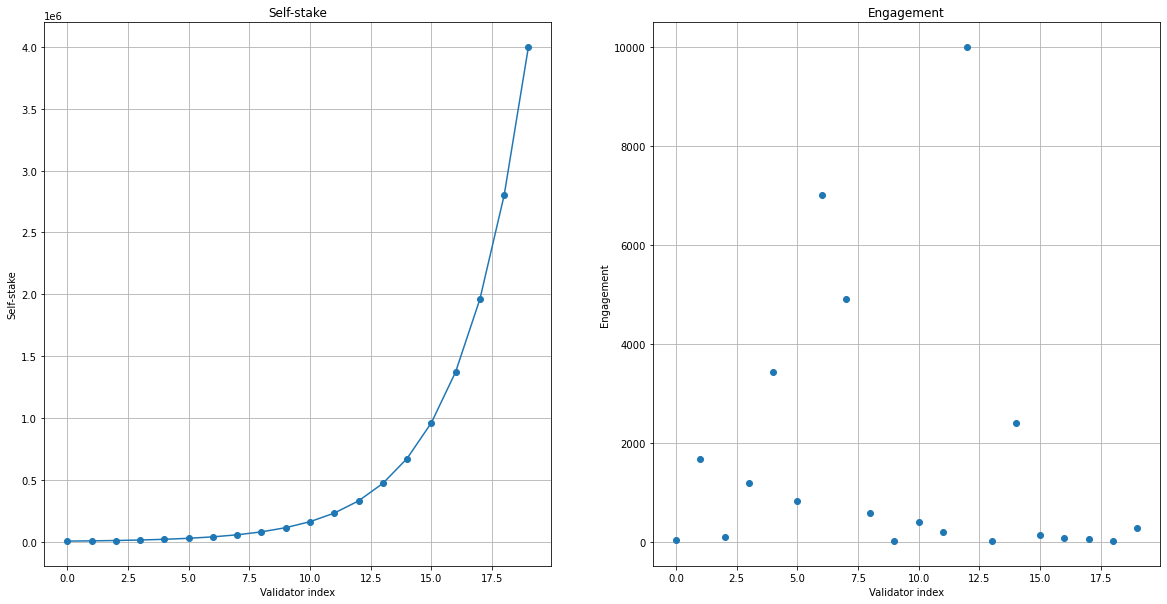

In [27]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(self_stakes_poe_uncorrelated, marker='o')
plt.title('Self-stake')
plt.xlabel('Validator index')
plt.ylabel('Self-stake')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(engagements_poe_uncorrelated, 'o')
plt.title('Engagement')
plt.xlabel('Validator index')
plt.ylabel('Engagement')
plt.grid()

plt.show()

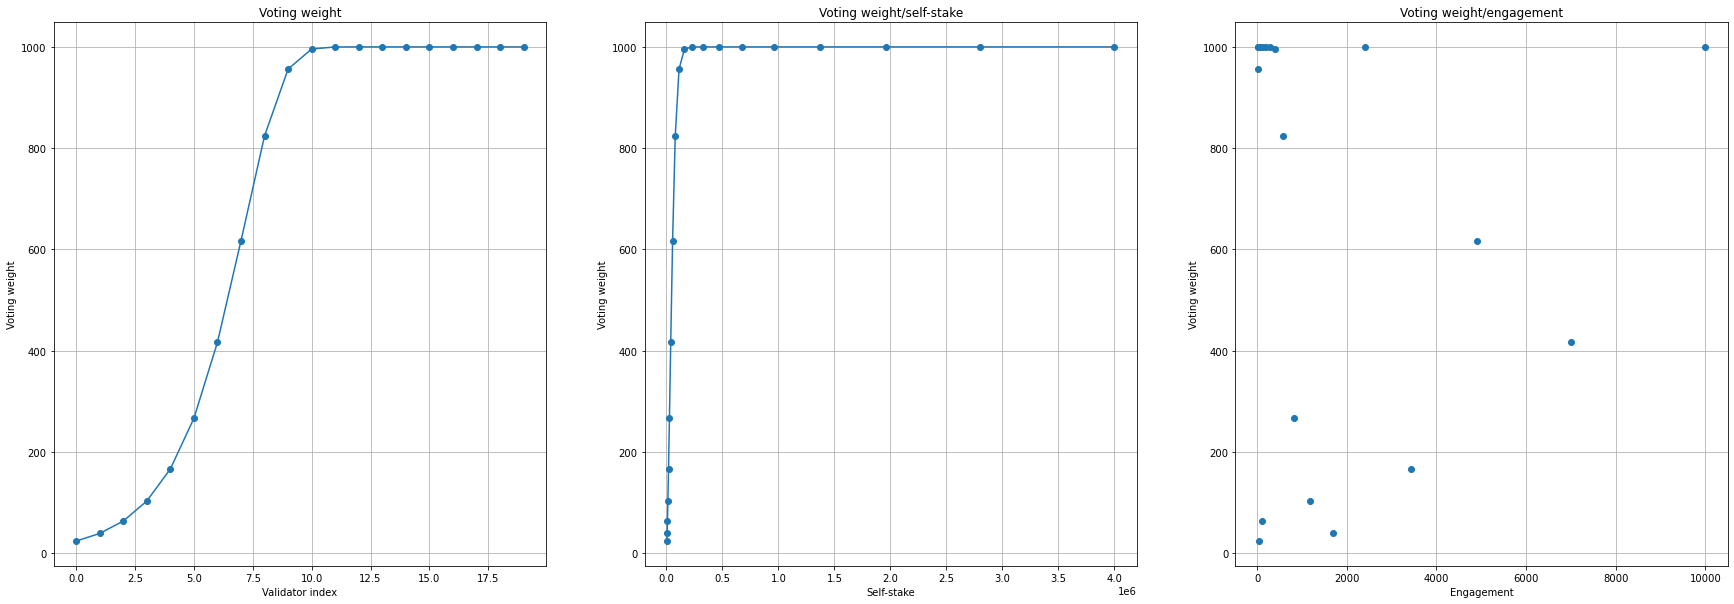

In [28]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.plot(voting_weights_poe_uncorrelated, marker='o')
plt.title('Voting weight')
plt.xlabel('Validator index')
plt.ylabel('Voting weight')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(self_stakes_poe_uncorrelated, voting_weights_poe_uncorrelated, marker='o')
plt.title('Voting weight/self-stake')
plt.xlabel('Self-stake')
plt.ylabel('Voting weight')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(engagements_poe_uncorrelated, voting_weights_poe_uncorrelated, 'o')
plt.title('Voting weight/engagement')
plt.xlabel('Engagement')
plt.ylabel('Voting weight')
plt.grid()

plt.show()

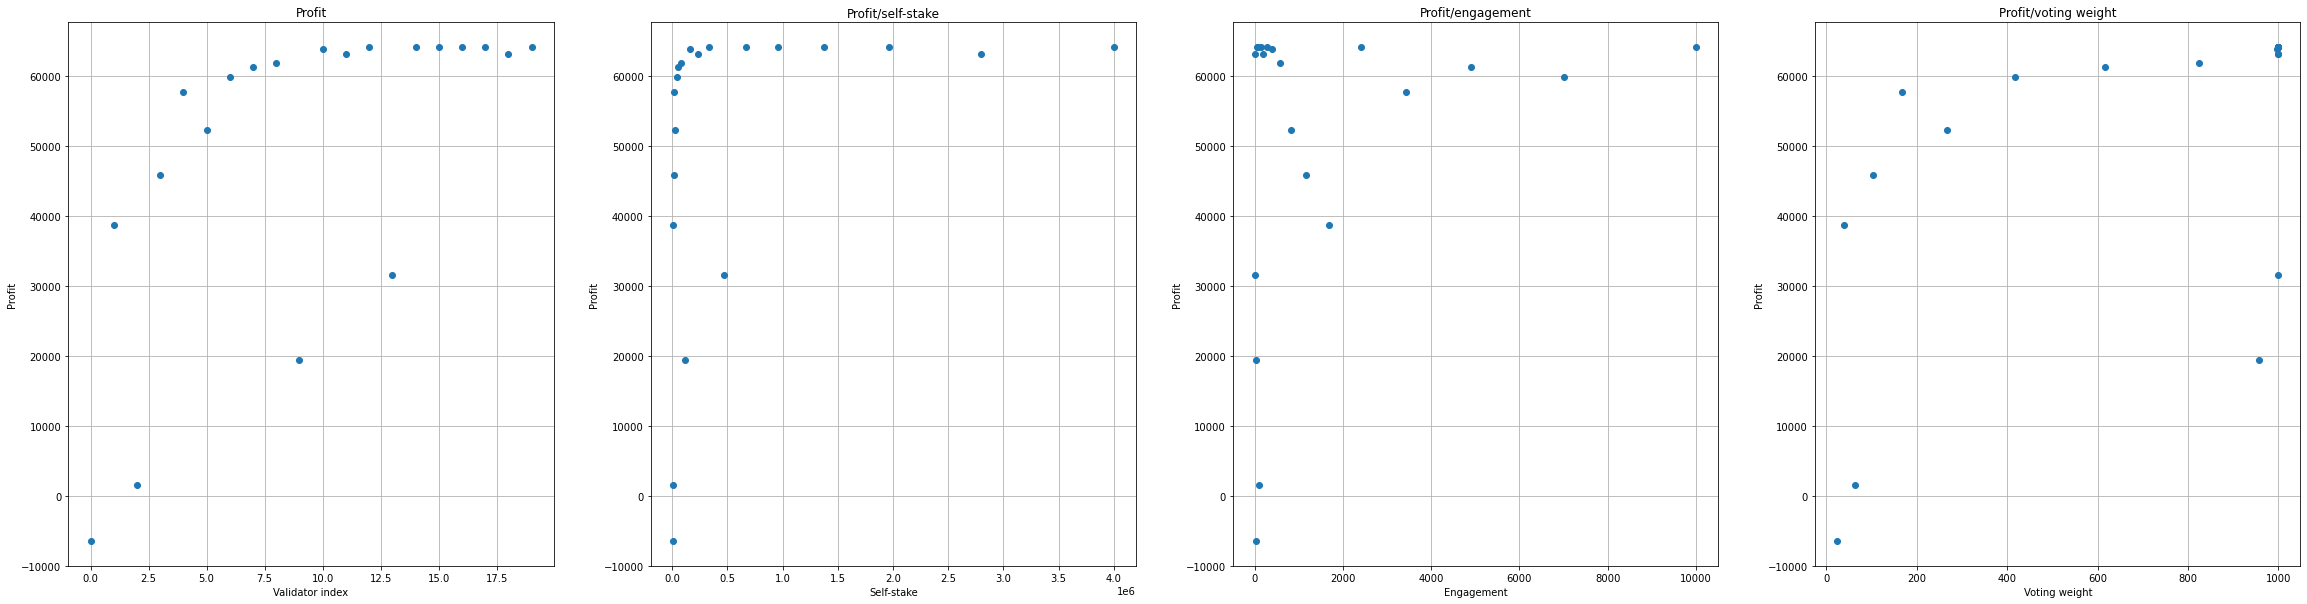

In [29]:
plt.figure(figsize=(40, 10))

plt.subplot(1, 4, 1)
plt.plot(profits_poe_uncorrelated, 'o')
plt.title('Profit')
plt.xlabel('Validator index')
plt.ylabel('Profit')
plt.grid()

plt.subplot(1, 4, 2)
plt.plot(self_stakes_poe_uncorrelated, profits_poe_uncorrelated, 'o')
plt.title('Profit/self-stake')
plt.xlabel('Self-stake')
plt.ylabel('Profit')
plt.grid()

plt.subplot(1, 4, 3)
plt.plot(engagements_poe_uncorrelated, profits_poe_uncorrelated, 'o')
plt.title('Profit/engagement')
plt.xlabel('Engagement')
plt.ylabel('Profit')
plt.grid()

plt.subplot(1, 4, 4)
plt.plot(voting_weights_poe_uncorrelated, profits_poe_uncorrelated, 'o')
plt.title('Profit/voting weight')
plt.xlabel('Voting weight')
plt.ylabel('Profit')
plt.grid()

plt.show()

In [30]:
gini_coefficient_poe_uncorrelated = calculate_gini_coefficient(voting_weights_poe_uncorrelated)
print(f'PoE (uncorrelated) Gini coefficient: %f' % gini_coefficient_poe_uncorrelated)

PoE (uncorrelated) Gini coefficient: 0.307720
